## CO2 Limit

In [1]:
import pypsa
import pandas as pd

In [5]:
prefix = "/mnt/c/Users/scl38887/Documents/git/aldehyde"
prefix_eur = "/mnt/c/Users/scl38887/Documents/git/pypsa-eur"

# /mnt/c/Users/scl38887/Documents/git/pypsa-eur/results/carbontest/postnetworks/elec_s_37_lv1.0__Co2L0p25-2000H-T-H-B-I-A-solar+p3-dist1_2030.nc

# Import from pypsa-earth-sec
run = "newres_300h_ws" #"wacc15_hem_1marg_1cap_nosmr_0exp_3h_ws"
run_eur = "carbontest"
Co2Ls = ["Co2L20.0", "Co2L5.0", "Co2L2.0", "Co2L1.7", "Co2L1.2", "Co2L1.0", "Co2L0.50", "Co2L0.10"] 
Co2Ls = ["Co2L2.0", "Co2L1.0", "Co2L0.7", "Co2L0.5","Co2L0.30", "Co2L0.10"] 
Co2Ls_eur = ["Co2L0p50", "Co2L0p25", "Co2L0p100"] 


carbon_stats = pd.DataFrame(columns=["constraint", "store", "generators", "loads", "CO2seq", "dac", "biogas upgrading", "links"])

for Co2L in Co2Ls:
    n = pypsa.Network(prefix + "/workflow/subworkflows/pypsa-earth-sec/results/" + run + "/postnetworks/elec_s_10_ec_lc1.0_"+Co2L+"_300H_2030_0.15_DF_0export.nc")
    # n = pypsa.Network(prefix_eur + "/results/" + run_eur + "/postnetworks/elec_s_37_lv1.0__"+Co2L+"-2000H-T-H-B-I-A-solar+p3-dist1_2030.nc")


    carbon_stats.loc[Co2L, "constraint"] = n.global_constraints.loc["CO2Limit", "constant"] / 1e6 # MtCO2

    carbon_stats.loc[Co2L, "store"] = n.stores_t.e.filter(like="co2 atmosphere").iloc[-1][0] / 1e6 # MtCO2
    
    emissions_generator = n.generators_t.p / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions) # t/h
    carbon_stats.loc[Co2L, "generators"] = n.snapshot_weightings.generators @ emissions_generator.sum(axis=1).div(1e6) # MtCO2

    carbon_stats.loc[Co2L, "loads"] = n.loads[n.loads.bus == "co2 atmosphere"].p_set.sum() * (-1) * 8760/1e6 # MtCO2

    carbon_stats.loc[Co2L, "CO2seq"]=n.stores[n.stores.carrier == "co2 stored"].e_nom_opt.sum() * (-1) / 1e6 # in MtCO2

    links2= (n.links_t.p0[n.links[n.links.bus2 == "co2 atmosphere"].index] * n.links.efficiency2[n.links[n.links.bus2 == "co2 atmosphere"].index]).sum().sum() / 1e6 * n.snapshot_weightings.generators[0] # in Mt

    links3= (n.links_t.p0[n.links[n.links.bus3 == "co2 atmosphere"].index] * n.links.efficiency3[n.links[n.links.bus3 == "co2 atmosphere"].index]).sum().sum() / 1e6 * n.snapshot_weightings.generators[0] # in Mt

    links4= (n.links_t.p0[n.links[n.links.bus4 == "co2 atmosphere"].index] * n.links.efficiency4[n.links[n.links.bus4 == "co2 atmosphere"].index]).sum().sum() / 1e6 * n.snapshot_weightings.generators[0] # in Mt

    carbon_stats.loc[Co2L, "links"] = links2 + links3 + links4

    carbon_stats.loc[Co2L, "dac"] = n.links_t.p0[n.links[n.links.carrier == "DAC"].index].sum().sum() / 1e6 * n.snapshot_weightings.generators[0] # in Mt

    carbon_stats.loc[Co2L, "biogas upgrading"] = n.links_t.p0[n.links[n.links.carrier == "biogas to gas"].index].sum().sum() / 1e6 * n.snapshot_weightings.generators[0] * n.links[n.links.carrier == "biogas to gas"].efficiency2[0] # in MtCO2

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L2.0_300H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L1.0_300H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.7_300H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.5_300H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.30_300H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_300H_2030_0.15_DF_0export

In [6]:
# Multiply the numeric part of the index by 40 and set it as new index
#carbon_stats.index = carbon_stats.index.str[4:].astype(float) * 40

carbon_stats["sto + gen + loads"] = carbon_stats["store"] + carbon_stats["generators"] + carbon_stats["loads"]
carbon_stats["sto + gen"] = carbon_stats["store"] + carbon_stats["generators"]
carbon_stats["gen + loads + seq"] = carbon_stats["loads"] + carbon_stats["generators"] + carbon_stats["CO2seq"]
carbon_stats["diff"] = carbon_stats["constraint"] - carbon_stats["sto + gen + loads"]
carbon_stats["neg_em"] = - carbon_stats["dac"] + carbon_stats["biogas upgrading"]
carbon_stats.astype(float).round(2)

,constraint,store,generators,loads,CO2seq,dac,biogas upgrading,links,sto + gen + loads,sto + gen,gen + loads + seq,diff,neg_em
Co2L2.0,144.0,19.89,39.63,18.06,-0.00,0.00,-0.0,1.94,77.58,59.52,57.69,66.42,-0.00
Co2L1.0,72.0,19.89,39.62,18.06,-0.00,0.00,-0.0,1.93,77.57,59.51,57.68,-5.57,-0.00
Co2L0.7,50.4,18.73,31.67,18.06,-0.00,0.00,-0.0,0.72,68.46,50.40,49.74,-18.06,-0.00
Co2L0.5,36.0,18.69,17.31,18.06,-0.00,0.00,-0.0,0.68,54.06,36.00,35.37,-18.06,-0.00
Co2L0.30,21.6,18.45,3.15,18.06,-0.00,0.00,-0.0,0.43,39.66,21.60,21.21,-18.06,-0.00
Co2L0.10,7.2,7.20,0.00,18.06,-0.18,11.15,-0.1,0.01,25.26,7.20,17.88,-18.06,-11.25


In [7]:
# constraint - store - generators
carbon_stats["constraint"] - carbon_stats["store"] - carbon_stats["generators"]

Co2L2.0     84.484518
Co2L1.0     12.490833
Co2L0.7      0.000001
Co2L0.5      0.000001
Co2L0.30          0.0
Co2L0.10          0.0
dtype: object

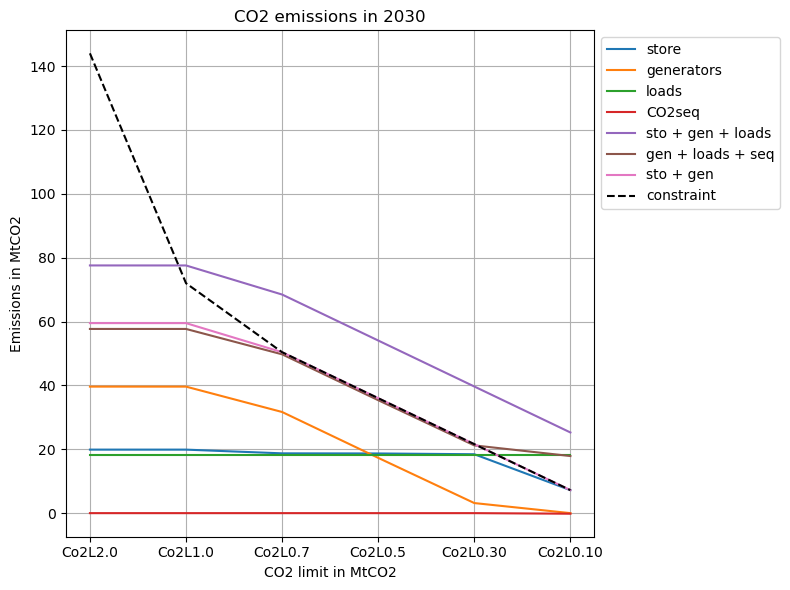

In [9]:
# Plot the carbon stats
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
carbon_stats[["store", "generators", "loads", "CO2seq","sto + gen + loads", "gen + loads + seq", "sto + gen"]].iloc[:,:].plot(ax=ax) 
carbon_stats["constraint"].iloc[:].plot(ax=ax, style="k--", label="constraint")
ax.set_ylabel("Emissions in MtCO2")
ax.set_xlabel("CO2 limit in MtCO2")
ax.set_title("CO2 emissions in 2030")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.grid()
fig.tight_layout()

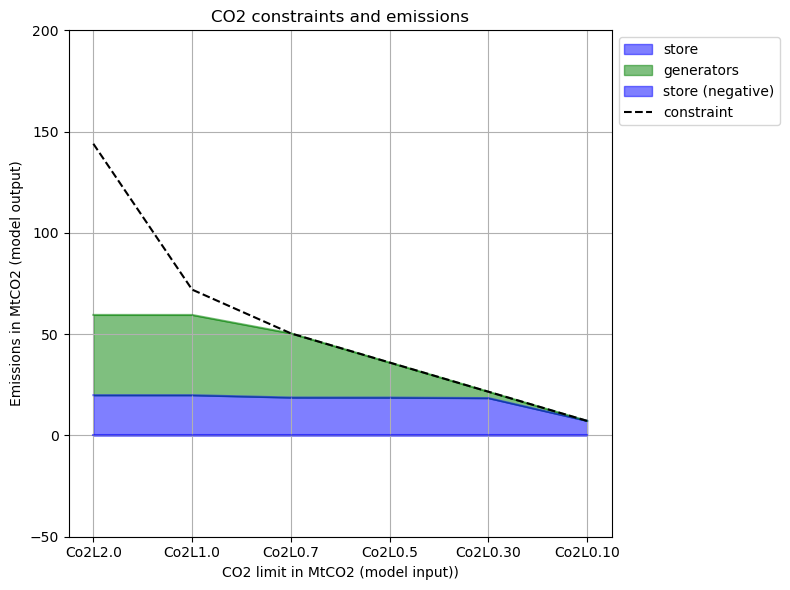

In [10]:
# Plot the carbon stats
import matplotlib.pyplot as plt

start_value = 0

# Create a stackplot + lineplot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot positive 'store' values together with 'generators' and 'loads'
positive_store = carbon_stats["store"].clip(lower=0).iloc[start_value:]
stacked_data = pd.concat([positive_store, carbon_stats[["generators"]].iloc[start_value:,:]], axis=1)
stacked_data.plot.area(ax=ax, stacked=True, color=["b", "g"], alpha = 0.5, label=["store (positive)", "generators"])

# Plot negative 'store' values separately
negative_store = carbon_stats["store"].clip(upper=0).iloc[start_value:]
negative_store.plot.area(ax=ax, stacked=True, color="b", alpha = 0.5, label="store (negative)")

# Plot the constraint
carbon_stats["constraint"].iloc[start_value:].plot(ax=ax, style="k--", label="constraint")

ax.set_ylabel("Emissions in MtCO2 (model output)")
ax.set_xlabel("CO2 limit in MtCO2 (model input))")
ax.set_title("CO2 constraints and emissions")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

ax.set_ylim(-50, 200)
ax.grid()

fig.tight_layout()
plt.show()


#### Supply_energy

In [104]:
sen = pd.read_csv(prefix + "/workflow/subworkflows/pypsa-earth-sec/results/" + run + "/csvs/supply_energy.csv", index_col=0, header=6)

### Ideas
- Instead of catching the emissions through the "store", is it possible to multiply carrier usage with their co2 intensity and sum it up?

### Investigate
- Check, wether the CO2 constraint on the carriers actually applies to the carriers by quantifying the carrier usage multiplied with their co2 intensity and summing it up
- Possible mistake: the carrier "land transport oil" is not listed in n.carriers but used for land transport. It's emissions are accounted in the `co2 atmosphere` store -> (Same as pypsa-eur!). But if there is no "land transport oil" carrier, how does the co2 constraint apply to it?
- Why is gas/OCGT modelled as a link (as well as a generator)?
- co2_absorptions is listed as carrier in pypsa-eur

### Explaination

General
-  There is urban central solid biomass CHP CC, which captures the CO2. Does it make sense that is the same side as DAC in `balances-co2_stored` ?
- PyPSA-Eur has "EU oil" generator, PyPSA-Earth-Sec does not

PyPSA-Eur implementation
- In `prepare_network.py` the function `add_co2limit()` is implemented (-> is this rule called also in the sector coupled version?)
- In `prepare_sector_network.py` the function `add_co2limit()` is implemented (adds the limit either from carbon budget or wildcard). 

PyPSA-Earth-Sec implementaion
- bla

PyPSA-Earth implementation
- The CO2 constraint is set on the carrier (on the carrier attribute "co2_emissions")
- The value in `n.stores_t.e.filter(like="co2 atmosphere").iloc[-1][0]` is equivalent to "co2" in the graph `balances-co2.pdf`. If the value is negative, it is displayed as positive in the graph
- The value in `n.stores_t.e.filter(like="co2 atmosphere").iloc[-1][0]` does not include electricity/generation emissions and oil emissions modelled as "loads"
- Through biogas upgrading, it removes co2emissions from the atmosphere (not in reality, but as a balance)
- The CO2 emission factors of the carriers are implemented correctly
- See here: [prepare_network.py](https://github.com/pypsa-meets-earth/pypsa-earth/blob/aab4d18542466e3ffd89cf5af19f5be99aabdf6a/scripts/prepare_network.py#LL74C1-L81C6): 
    ```python
    def add_co2limit(n, annual_emissions, Nyears=1.0):
        n.add(
            "GlobalConstraint",
            "CO2Limit",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=annual_emissions * Nyears,
        )
    ```

Check CHP usage

In [11]:
n.statistics().loc["Link"][n.statistics().loc["Link"].index.str.contains("CHP")].round(2)

,Capacity Factor,Capital Expenditure,Curtailment,Installed Capacity,Operational Expenditure,Optimal Capacity,Revenue,Supply,Withdrawal
carrier,,,,,,,,,
urban central gas CHP,0.19,7423.80,NaN,0.0,0.14,0.17,1.94,0.01,-0.03
urban central gas CHP CC,0.54,21125.22,NaN,0.0,0.33,0.15,4.13,0.03,-0.08


Check Biogas usage

In [50]:
n.statistics().loc["Link"][n.statistics().loc["Link"].index.str.contains("bio")].round(2)

,Capacity Factor,Capital Expenditure,Curtailment,Installed Capacity,Operational Expenditure,Optimal Capacity,Revenue,Supply,Withdrawal
carrier,,,,,,,,,
biogas to gas,1.00,5.525198e+08,NaN,0.0,23607.61,7402.03,-283205.71,7401.13,-7401.13
biomass EOP,0.41,1.403531e+05,NaN,0.0,0.20,0.77,18.84,0.09,-0.31
solid biomass for industry,inf,0.000000e+00,NaN,0.0,-0.00,0.00,0.00,0.00,-0.00
solid biomass for industry CC,0.00,3.009100e+03,NaN,0.0,0.00,0.02,-0.00,0.00,-0.00
solid biomass transport,0.00,1.992530e+05,NaN,0.0,29.62,25176.53,0.00,4.63,-4.63


Check CO2 stores

In [51]:
n.stores[n.stores.index.str.contains("co2 atmosphere")]

,bus,capital_cost,carrier,e_cyclic,e_initial,e_min_pu,e_nom,e_nom_extendable,lifetime,marginal_cost,...,type,e_nom_min,e_nom_max,e_max_pu,e_initial_per_period,e_cyclic_per_period,p_set,q_set,sign,build_year
Store,,,,,,,,,,,,,,,,,,,,,
co2 atmosphere,co2 atmosphere,0.0,co2,False,0.0,-1.0,0.0,True,inf,0.00992,...,,0.0,inf,1.0,False,True,0.0,0.0,1.0,0


In [52]:
n.stores_t.e["co2 atmosphere"][-1]/1e6 # MtCO2
# equivalent to n.stores_t.e.filter(like="co2 atmosphere").iloc[-1][0]/ 1e6 # MtCO2
# equivalent to (n.stores_t.p["co2 atmosphere"]*n.snapshot_weightings.generators[0]).sum()/1e6 # MtCO2

-15.191386448535619

CO2 sequestration

In [53]:
n.stores[n.stores.carrier == "co2 stored"].e_nom_opt.sum() / 1e6 # in MtCO2

33.133126337551836

### Check CO2 balances: links, generators, stores, loads

Generators

In [54]:
# Of course no generator feed directly in into co2 atmosphere, but the carrier is constraint
n.generators[n.generators.bus == "co2 atmosphere"].carrier.unique()

array([], dtype=object)

Stores

In [55]:
# Lets see the stores
n.stores[n.stores.index.str.contains("co2 atmosphere")]

,bus,capital_cost,carrier,e_cyclic,e_initial,e_min_pu,e_nom,e_nom_extendable,lifetime,marginal_cost,...,type,e_nom_min,e_nom_max,e_max_pu,e_initial_per_period,e_cyclic_per_period,p_set,q_set,sign,build_year
Store,,,,,,,,,,,,,,,,,,,,,
co2 atmosphere,co2 atmosphere,0.0,co2,False,0.0,-1.0,0.0,True,inf,0.00992,...,,0.0,inf,1.0,False,True,0.0,0.0,1.0,0


In [56]:
n.stores[n.stores.bus == "co2 atmosphere"]

,bus,capital_cost,carrier,e_cyclic,e_initial,e_min_pu,e_nom,e_nom_extendable,lifetime,marginal_cost,...,type,e_nom_min,e_nom_max,e_max_pu,e_initial_per_period,e_cyclic_per_period,p_set,q_set,sign,build_year
Store,,,,,,,,,,,,,,,,,,,,,
co2 atmosphere,co2 atmosphere,0.0,co2,False,0.0,-1.0,0.0,True,inf,0.00992,...,,0.0,inf,1.0,False,True,0.0,0.0,1.0,0


In [57]:
n.stores[n.stores.carrier == "co2 stored"]#.e_nom_opt.sum() / 1e6 # in MtCO2

,bus,capital_cost,carrier,e_cyclic,e_initial,e_min_pu,e_nom,e_nom_extendable,lifetime,marginal_cost,...,type,e_nom_min,e_nom_max,e_max_pu,e_initial_per_period,e_cyclic_per_period,p_set,q_set,sign,build_year
Store,,,,,,,,,,,,,,,,,,,,,
MA.1.1_1_AC co2 stored,MA.1.1_1_AC co2 stored,10.0,co2 stored,False,0.0,0.0,0.0,True,inf,0.010793,...,,0.0,inf,1.0,False,True,0.0,0.0,1.0,0
MA.1.2_1_AC co2 stored,MA.1.2_1_AC co2 stored,10.0,co2 stored,False,0.0,0.0,0.0,True,inf,0.009380,...,,0.0,inf,1.0,False,True,0.0,0.0,1.0,0
MA.1.3_1_AC co2 stored,MA.1.3_1_AC co2 stored,10.0,co2 stored,False,0.0,0.0,0.0,True,inf,0.009412,...,,0.0,inf,1.0,False,True,0.0,0.0,1.0,0
MA.10.1_1_AC co2 stored,MA.10.1_1_AC co2 stored,10.0,co2 stored,False,0.0,0.0,0.0,True,inf,0.010034,...,,0.0,inf,1.0,False,True,0.0,0.0,1.0,0
MA.10.3_1_AC co2 stored,MA.10.3_1_AC co2 stored,10.0,co2 stored,False,0.0,0.0,0.0,True,inf,0.009139,...,,0.0,inf,1.0,False,True,0.0,0.0,1.0,0
MA.10.4_1_AC co2 stored,MA.10.4_1_AC co2 stored,10.0,co2 stored,False,0.0,0.0,0.0,True,inf,0.010517,...,,0.0,inf,1.0,False,True,0.0,0.0,1.0,0
MA.10.5_1_AC co2 stored,MA.10.5_1_AC co2 stored,10.0,co2 stored,False,0.0,0.0,0.0,True,inf,0.010609,...,,0.0,inf,1.0,False,True,0.0,0.0,1.0,0
MA.11.1_1_AC co2 stored,MA.11.1_1_AC co2 stored,10.0,co2 stored,False,0.0,0.0,0.0,True,inf,0.010784,...,,0.0,inf,1.0,False,True,0.0,0.0,1.0,0
MA.11.3_1_AC co2 stored,MA.11.3_1_AC co2 stored,10.0,co2 stored,False,0.0,0.0,0.0,True,inf,0.009102,...,,0.0,inf,1.0,False,True,0.0,0.0,1.0,0


Loads

In [58]:
n.loads[n.loads.bus == "co2 atmosphere"]

,bus,carrier,p_set,type,q_set,sign
Load,,,,,,
industry oil emissions,co2 atmosphere,industry oil emissions,-0.000000,,0.0,-1.0
shipping oil emissions,co2 atmosphere,shipping oil emissions,-311.795205,,0.0,-1.0
aviation oil emissions,co2 atmosphere,oil emissions,-267.740223,,0.0,-1.0
land transport oil emissions,co2 atmosphere,land transport oil emissions,-1473.433121,,0.0,-1.0


In [59]:
n.loads[n.loads.bus == "co2 atmosphere"].p_set.sum() * 8760/1e6 # MtCO2

-17.984004494442807

Links (Biogas and DAC)

In [60]:
# DAC
n.links_t.p0[n.links[n.links.carrier == "DAC"].index].sum().sum() / 1e6 * n.snapshot_weightings.generators[0] # in Mt

21.665817481942707

In [61]:
# Biogas to gas
n.links_t.p0[n.links[n.links.carrier == "biogas to gas"].index].sum().sum() / 1e6 * n.snapshot_weightings.generators[0] * n.links[n.links.carrier == "biogas to gas"].efficiency2[0] # in MtCO2

-12.966781879072142

Links (CO2 vents)

In [62]:
# CO2 vent
# n.links_t.p0[n.links[n.links.carrier == "co2 vent"].index].sum().sum() / 1e6 * n.snapshot_weightings.generators[0] * n.links[n.links.carrier == "co2 vent"].efficiency2[0] # in MtCO2

Links (solid biomass for industry CC)

In [63]:
# Solid biomass for industry CC
n.links_t.p0[n.links[n.links.carrier == "solid biomass for industry CC"].index].sum().sum() / 1e6 * n.snapshot_weightings.generators[0] * n.links[n.links.carrier == "solid biomass for industry CC"].efficiency2[0] # in MtCO2

-7.57317339439924e-09

Other Links

In [64]:
# Show all input and outputs of the bus "co2 atmosphere"
n.links[n.links.bus2 == "co2 atmosphere"].carrier.unique()

array(['OCGT', 'biomass EOP', 'biogas to gas',
       'residential rural gas boiler', 'services rural gas boiler',
       'residential urban decentral gas boiler',
       'services urban decentral gas boiler', 'urban central gas boiler',
       'solid biomass for industry CC', 'gas for industry',
       'gas for industry CC'], dtype=object)

In [65]:
test = (n.links_t.p0[n.links[n.links.bus2 == "co2 atmosphere"].index] * n.links.efficiency2[n.links[n.links.bus2 == "co2 atmosphere"].index]).sum().sort_values() * n.snapshot_weightings.generators[0] / 1e6 #.sum().sum() / 1e6 # in Mt

In [66]:
test.sum().sum()

-12.789759097539855

In [67]:
n.loads[n.loads.bus == "process emissions"].p_set.sum() * 8760/1e6 # MtCO2

0.0

In [68]:
n.links[n.links.carrier == "co2 stored"]

,bus0,bus1,carrier,efficiency,p_nom_extendable,bus2,bus3,bus4,capital_cost,efficiency2,...,charger_ratio,type,build_year,p_nom_min,p_nom_max,p_set,p_max_pu,terrain_factor,ramp_limit_up,ramp_limit_down
Link,,,,,,,,,,,,,,,,,,,,,


### Check PyPSA-Eur for comparison

In [69]:
# Check carriers of pypsa-eur
n_eur = pypsa.Network("/mnt/c/Users/scl38887/Documents/git/pypsa-eur/results/testrun/postnetworks/elec_s_37_lv1.0__Co2L0-2000H-T-H-B-I-A-solar+p3-dist1_2050.nc")
#n_eur.carriers.index.str.contains("oil")
n_eur.generators.carrier.unique()

INFO:pypsa.io:Imported network elec_s_37_lv1.0__Co2L0-2000H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


array(['offwind-ac', 'onwind', 'ror', 'solar', 'offwind-dc', 'gas',
       'residential rural solar thermal', 'services rural solar thermal',
       'residential urban decentral solar thermal',
       'services urban decentral solar thermal',
       'urban central solar thermal', 'oil', 'solar rooftop'],
      dtype=object)

In [76]:
n_eur.carriers

,co2_emissions,color,nice_name,co2_absorptions,max_growth,max_relative_growth
Carrier,,,,,,
geothermal,0.03,#ba91b1,Geothermal,0.0,inf,0.0
solar,0.00,#f9d002,Solar,0.0,inf,0.0
onwind,0.00,#235ebc,Onshore Wind,0.0,inf,0.0
offwind-ac,0.00,#6895dd,Offshore Wind (AC),0.0,inf,0.0
offwind-dc,0.00,#74c6f2,Offshore Wind (DC),0.0,inf,0.0
hydro,0.00,#298c81,Reservoir & Dam,0.0,inf,0.0
PHS,0.00,#51dbcc,Pumped Hydro Storage,0.0,inf,0.0
ror,0.00,#3dbfb0,Run of River,0.0,inf,0.0
co2,-1.00,,,0.0,inf,0.0


In [70]:
n.generators[n.generators.carrier == "oil"]   

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,bus,carrier,p_nom_extendable,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
MA.12.6_1_AC oil,inf,0.0,211.386221,61499.694996,0.35,211.386221,148.868076,MA.12.6_1_AC,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
MA.14.5_1_AC oil,inf,0.0,134.318647,61499.694996,0.35,134.318647,148.867075,MA.14.5_1_AC,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
MA.4.1_1_AC oil,inf,0.0,277.900649,61499.694996,0.35,277.900649,148.867387,MA.4.1_1_AC,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
MA.5.1_1_AC oil,inf,0.0,188.972441,61499.694996,0.35,188.972441,148.866741,MA.5.1_1_AC,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
MA.5.2_1_AC oil,inf,0.0,925.409160,61499.694996,0.35,925.409160,148.866508,MA.5.2_1_AC,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


In [71]:
n_eur.generators[n_eur.generators.carrier == "oil"]

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,carrier,p_nom_extendable,bus,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
EU oil,inf,NaN,0.0,0.0,1.0,0.0,50.010316,oil,True,EU oil,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


In [72]:
n_eur.global_constraints

,type,carrier_attribute,sense,constant,investment_period,mu
GlobalConstraint,,,,,,
lv_limit,transmission_volume_expansion_limit,"AC, DC",<=,1.511434e+08,NaN,0.0
CO2Limit,primary_energy,co2_emissions,<=,0.000000e+00,NaN,0.0
co2_sequestration_limit,primary_energy,co2_absorptions,<=,2.000000e+08,NaN,0.0


In [73]:
n.global_constraints

,type,carrier_attribute,sense,constant,investment_period,mu
GlobalConstraint,,,,,,
CO2Limit,primary_energy,co2_emissions,<=,4.000000e+06,NaN,0.0
lc_limit,transmission_expansion_cost_limit,"AC, DC",<=,9.838156e+08,NaN,0.0


### Check carriers

In [77]:
# Set the "co2_emissions" of the carrier "oil" to 0
n.carriers.loc["oil", "co2_emissions"] = 0

In [78]:
n.carriers #.index.str.contains("oil")

,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
lignite,0.41,#9e5a01,Lignite,inf,0.0
biomass,0.00,#0c6013,Biomass,inf,0.0
geothermal,0.03,#ba91b1,Geothermal,inf,0.0
CCGT,0.20,#b20101,Combined-Cycle Gas,inf,0.0
solar,0.00,#f9d002,Solar,inf,0.0
onwind,0.00,#235ebc,Onshore Wind,inf,0.0
oil,0.00,#262626,Oil,inf,0.0
coal,0.34,#707070,Coal,inf,0.0
offwind-ac,0.00,#6895dd,Offshore Wind (AC),inf,0.0


Show output of a single carrier

In [75]:
carrier = "coal"
total_usage = 0.0

# Iterate over the generators
for _, gen in n_highem.generators.iterrows():
    total_usage += n_highem.generators_t.p[gen.name].sum() * n.snapshot_weightings.generators[0] if gen.carrier.upper() == carrier.upper() else 0.0

# Iterate over the links
for _, link in n_highem.links.iterrows():
    total_usage += n_highem.links_t.p0[link.name].sum() * n.snapshot_weightings.links[0] if link.carrier.upper() == carrier.upper() else 0.0
    


print(f"Total {carrier} usage: {total_usage/1e3:.2f} GWh")


NameError: name 'n_highem' is not defined

In [19]:
# Read high emission network (Co2L = 20.0)
Co2L = "Co2L2.0"
n_highem = pypsa.Network(prefix + "/workflow/subworkflows/pypsa-earth-sec/results/" + run + "/postnetworks/elec_s_10_ec_lc1.0_"+Co2L+"_300H_2030_0.15_DF_0export.nc")

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L2.0_300H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


More efficiently calculate the CO2 emissions of a carrier

In [ ]:
n_highem = n

In [ ]:
emissions = n_highem.generators_t.p / n_highem.generators.efficiency * n_highem.generators.carrier.map(n_highem.carriers.co2_emissions) # t/h

In [ ]:
n_highem.snapshot_weightings.generators @ emissions.sum(axis=1).div(1e6) # Mt

0.0

In [ ]:
n.generators[n.generators.carrier == "oil"] #.p_nom_opt.sum() / 1e3 # GW

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,carrier,bus,p_nom_extendable,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
EU oil,inf,NaN,0.0,0.0,1.0,0.0,50.010875,oil,EU oil,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


In [ ]:
n.carriers #.co2_emissions.sort_values()

,co2_emissions,color,nice_name,co2_absorptions,max_growth,max_relative_growth
Carrier,,,,,,
offwind-dc,0.00,#74c6f2,Offshore Wind (DC),0.0,inf,0.0
geothermal,0.03,#ba91b1,Geothermal,0.0,inf,0.0
offwind-ac,0.00,#6895dd,Offshore Wind (AC),0.0,inf,0.0
solar,0.00,#f9d002,Solar,0.0,inf,0.0
onwind,0.00,#235ebc,Onshore Wind,0.0,inf,0.0
hydro,0.00,#298c81,Reservoir & Dam,0.0,inf,0.0
PHS,0.00,#51dbcc,Pumped Hydro Storage,0.0,inf,0.0
ror,0.00,#3dbfb0,Run of River,0.0,inf,0.0
co2,-1.00,,,0.0,inf,0.0


Does this include oil (and maybe other) generators?

In [ ]:
n.generators[n.generators.carrier =="oil"]
# No,just actual oil generators

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,bus,carrier,p_nom_extendable,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
MA.12.6_1_AC oil,inf,0.0,211.386221,61499.694996,0.35,211.386221,148.868076,MA.12.6_1_AC,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
MA.14.5_1_AC oil,inf,0.0,134.318647,61499.694996,0.35,134.318647,148.867075,MA.14.5_1_AC,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
MA.4.1_1_AC oil,inf,0.0,277.900649,61499.694996,0.35,277.900649,148.867387,MA.4.1_1_AC,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
MA.5.1_1_AC oil,inf,0.0,188.972441,61499.694996,0.35,188.972441,148.866741,MA.5.1_1_AC,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
MA.5.2_1_AC oil,inf,0.0,925.409160,61499.694996,0.35,925.409160,148.866508,MA.5.2_1_AC,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


Oil usage (store)

In [ ]:
n.stores_t.p[n.stores[n.stores.carrier == "oil"].index].sum().sum() * n.snapshot_weightings.stores[0] / 1e6 # TWh

69.55308956329087

In [ ]:
n.global_constraints

,type,carrier_attribute,sense,constant,investment_period,mu
GlobalConstraint,,,,,,
CO2Limit,primary_energy,co2_emissions,<=,4.000000e+06,NaN,0.0
lc_limit,transmission_expansion_cost_limit,"AC, DC",<=,9.838156e+08,NaN,0.0


In [ ]:
# Links connected to the co2 atmosphere. OCGT/ Gas is added here: https://github.com/PyPSA/pypsa-eur/blob/master/scripts/prepare_sector_network.py#L767
n.links[n.links.bus2 == "co2 atmosphere"].carrier.unique() #.bus

array(['OCGT', 'biomass EOP', 'biogas to gas',
       'residential rural gas boiler', 'services rural gas boiler',
       'residential urban decentral gas boiler',
       'services urban decentral gas boiler', 'urban central gas boiler',
       'solid biomass for industry CC', 'gas for industry',
       'gas for industry CC'], dtype=object)

#### Check coal capacity

In [23]:
n.generators[n.generators.carrier == "OCGT"] #.p_nom.sum() / 1e3 

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,bus,carrier,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,


In [17]:
n.statistics().loc["Generator"].round(2)

,Capacity Factor,Capital Expenditure,Curtailment,Installed Capacity,Operational Expenditure,Optimal Capacity,Revenue,Supply,Withdrawal
carrier,,,,,,,,,
Coal,0.00,1.308271e+09,0.00,5927.00,0.01,5927.00,0.03,0.00,0.0
Oil,0.01,1.163062e+08,0.00,1737.99,1685.25,1737.99,1687.68,12.94,0.0
Onshore Wind,0.15,2.583449e+08,95.21,1404.96,5.20,1404.98,13181.94,208.30,0.0
Run of River,0.11,2.444867e+08,0.81,479.38,0.48,479.38,2477.53,52.72,0.0
Solar,0.18,6.473777e+09,345.81,193.99,305.94,85142.24,741282.17,15634.22,0.0
gas,0.23,0.000000e+00,0.00,0.00,0.24,0.05,-0.33,0.01,0.0
residential rural solar thermal,0.08,2.722121e+05,0.20,0.00,0.01,11.64,29.96,0.95,0.0
residential urban decentral solar thermal,0.08,3.617789e+07,25.89,0.00,1.24,1547.58,4130.20,129.58,0.0
services rural solar thermal,0.05,1.077747e+04,0.02,0.00,0.00,0.46,0.11,0.02,0.0


In [20]:
n_highem.statistics().loc["Generator"].round(2)

,Capacity Factor,Capital Expenditure,Curtailment,Installed Capacity,Operational Expenditure,Optimal Capacity,Revenue,Supply,Withdrawal
carrier,,,,,,,,,
Coal,0.95,1.308271e+09,0.00,5927.00,136375.48,5927.00,256010.93,5655.60,0.0
Oil,0.01,1.163062e+08,0.00,1737.99,2189.72,1737.99,2189.50,16.81,0.0
Onshore Wind,0.22,2.583473e+08,0.04,1404.96,7.57,1404.99,11623.38,303.47,0.0
Run of River,0.11,2.444867e+08,0.00,479.38,0.49,479.38,1780.60,53.53,0.0
Solar,0.18,1.479063e+07,0.04,193.99,0.68,194.52,1537.60,34.28,0.0
gas,0.23,0.000000e+00,0.00,0.00,20981.48,4578.78,20979.82,1043.34,0.0
residential rural solar thermal,0.09,3.978245e+04,0.02,0.00,0.00,1.70,3.41,0.15,0.0
residential urban decentral solar thermal,0.11,8.633182e+05,0.02,0.00,0.04,36.93,97.45,4.13,0.0
services rural solar thermal,0.05,1.072273e+04,0.02,0.00,0.00,0.46,0.10,0.02,0.0
